# The Nature Conservancy

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
import pandas as pd
%matplotlib inline

In [2]:
TRAIN_DIR = 'data/fish/train/'
TEST_DIR = 'data/fish/test_stg1/'

sub_folders = check_output(["ls", TRAIN_DIR]).decode("utf8").strip().split('\n')

FISH_CLASSES = sub_folders

print(sub_folders)

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


**Посмотрим на тренировочную выборку**

In [3]:
img_width, img_height = 224, 224
num_channels = 3

def load_images(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height), cv2.INTER_LINEAR)
    return resized

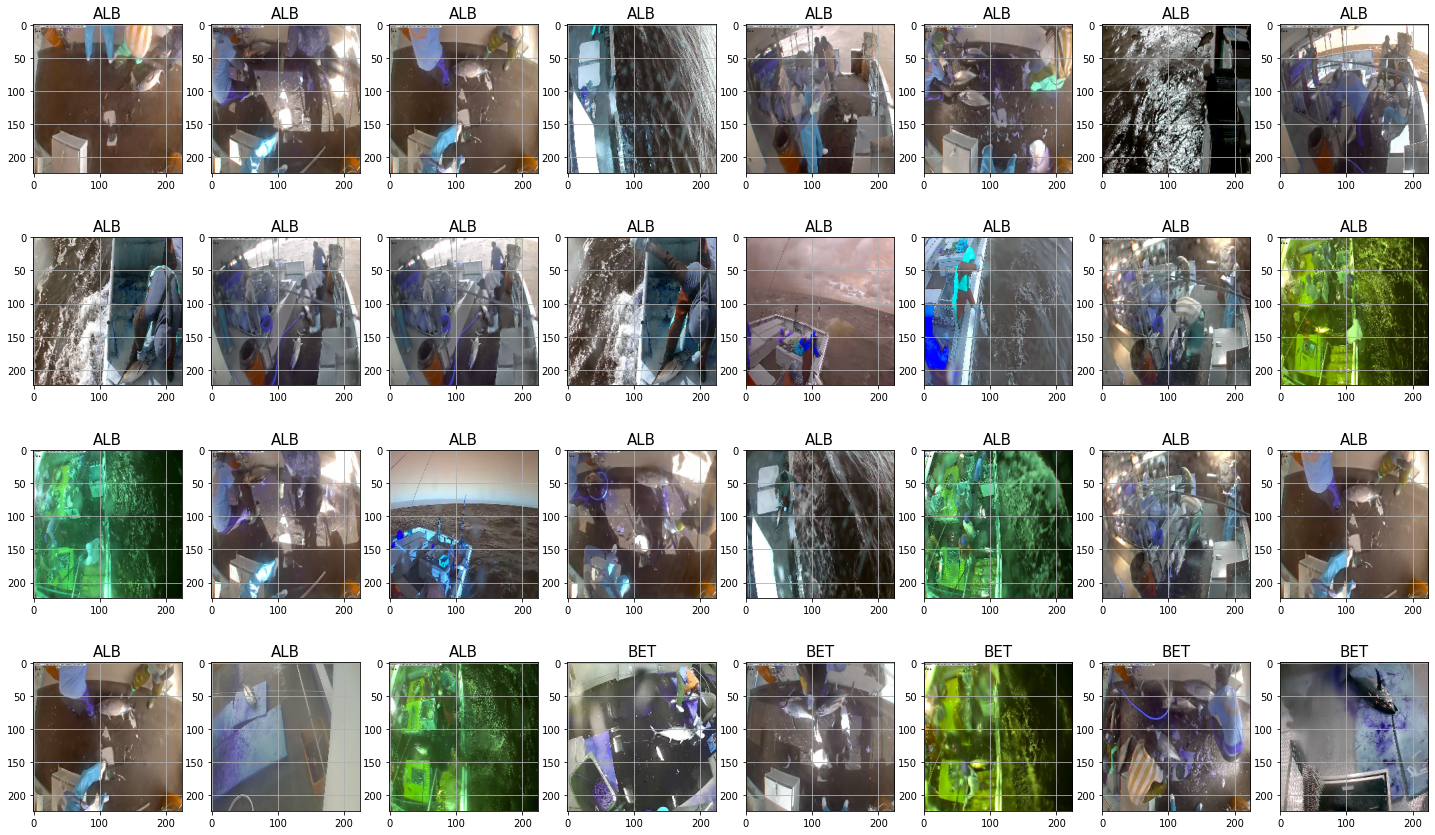

In [89]:
import glob

images = []
label_photos = []
images_path = []

for sub_dir in sub_folders:
    index = sub_folders.index(sub_dir)
    path = os.path.join(TRAIN_DIR, sub_dir, '*g')
    files = glob.glob(path)#'data/fish/train/YFT/img_07038.jpg'
    for file in files:
        file_name = os.path.basename(file)#'img_06053.jpg'
        img = load_images(file)#array([[[180, 202, 200]...
        images.append(img)#array([[[255, 255, 254]
        label_photos.append(sub_dir)
        images_path.append(file)

        
fig, axs = plt.subplots(4, 8, figsize=(25, 15))

for ax, img, label in zip(axs.flatten(), images, label_photos):
    ax.set_title(label, fontsize=15)
    ax.imshow(img)
    ax.grid(True)

plt.show()        
        

**Сформируем датасет для классификации рыб**

In [10]:
label_photos[25:30]

['ALB', 'ALB', 'BET', 'BET', 'BET']

In [11]:
num_classes = len(np.unique(label_photos))
num_classes

8

In [13]:
df = pd.DataFrame()

df['path']=images_path
df['labels'] = label_photos

df

path labels
0   data/fish/train/ALB/img_00714.jpg    ALB
1   data/fish/train/ALB/img_07540.jpg    ALB
2   data/fish/train/ALB/img_01083.jpg    ALB
3   data/fish/train/ALB/img_04528.jpg    ALB
4   data/fish/train/ALB/img_02203.jpg    ALB
..                                ...    ...
59  data/fish/train/YFT/img_07107.jpg    YFT
60  data/fish/train/YFT/img_01767.jpg    YFT
61  data/fish/train/YFT/img_06919.jpg    YFT
62  data/fish/train/YFT/img_00395.jpg    YFT
63  data/fish/train/YFT/img_06053.jpg    YFT

[64 rows x 2 columns]

In [45]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, 
                                   test_size = 0.20, 
                                   random_state = 2)
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 51 validation 13


In [47]:
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (100, 100)

batch_size=2

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True)


train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',)

Found 51 validated image filenames belonging to 8 classes.


In [46]:
valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col="path",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',)

Found 13 validated image filenames belonging to 8 classes.


In [48]:
train_df.sample(n=1).reset_index(drop=True)

path labels
0  data/fish/train/NoF/img_03536.jpg    NoF

In [49]:
example_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    example_df,  
    x_col="path",
    y_col="labels",
    target_size=IMG_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


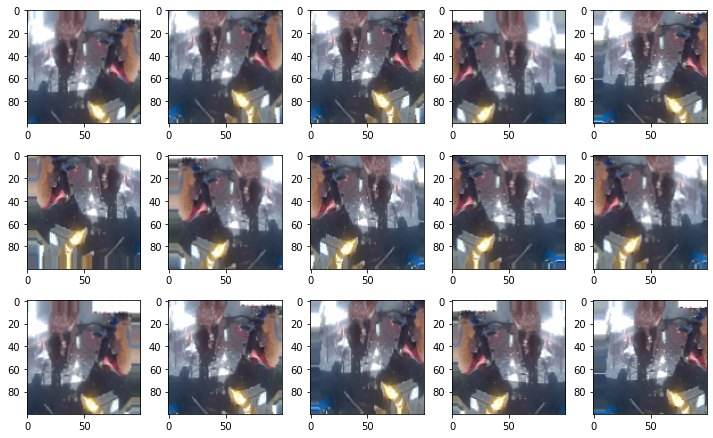

In [50]:
plt.figure(figsize=(10, 10))
for i in range(0, 15):
    plt.subplot(5, 5, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

**Обучение**

In [51]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers.normalization import BatchNormalization

In [52]:
num_classes

8

In [53]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet',#предварительное обучение на ImageNet
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [54]:
# дообучаем последние 5 слоев
for layer in base_model.layers[:-5]:
    layer.trainable = False
    print(layer)

In [55]:
from tensorflow.keras.layers import Flatten, Dense
import tensorflow as tf


x = base_model.layers[-1].output
x = tf.keras.layers.BatchNormalization()(x)
x = Flatten()(x)
x = Dense(num_classes,  
                          activation='softmax',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='detect_fish') 
model.summarymary()

Model: "detect_fish"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       

In [56]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [113]:
batch_size = 5

history=model.fit_generator(train_generator,
                    steps_per_epoch=train_df.shape[0]//batch_size,
                    validation_steps=valid_df.shape[0]//batch_size,
                    validation_data=valid_generator,
                    epochs = 15,
                    )

Epoch 1/15
10/10 [==============================] - 2s 165ms/step - loss: 0.0912 - accuracy: 0.9474 - val_loss: 0.6985 - val_accuracy: 0.0000e+00
Epoch 2/15
10/10 [==============================] - 2s 210ms/step - loss: 0.2730 - accuracy: 0.8000 - val_loss: 1.5201 - val_accuracy: 0.2500
Epoch 3/15
10/10 [==============================] - 3s 294ms/step - loss: 0.0789 - accuracy: 0.9500 - val_loss: 0.8606 - val_accuracy: 0.5000
Epoch 4/15
10/10 [==============================] - 2s 206ms/step - loss: 0.1048 - accuracy: 0.9500 - val_loss: 0.7879 - val_accuracy: 0.2500
Epoch 5/15
10/10 [==============================] - 2s 170ms/step - loss: 0.1607 - accuracy: 0.9000 - val_loss: 1.5849 - val_accuracy: 0.0000e+00
Epoch 6/15
10/10 [==============================] - 2s 161ms/step - loss: 0.1967 - accuracy: 0.7895 - val_loss: 1.0683 - val_accuracy: 0.2500
Epoch 7/15
10/10 [==============================] - 2s 177ms/step - loss: 0.1065 - accuracy: 0.8947 - val_loss: 0.9035 - val_accuracy: 0.250

In [115]:
print("Train Accuracy:{:.3f}".format(model.history.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(history.history['val_accuracy'][-1]))

Train Accuracy:0.950
Test Accuracy:0.250


**Классификация неразмеченных данных**

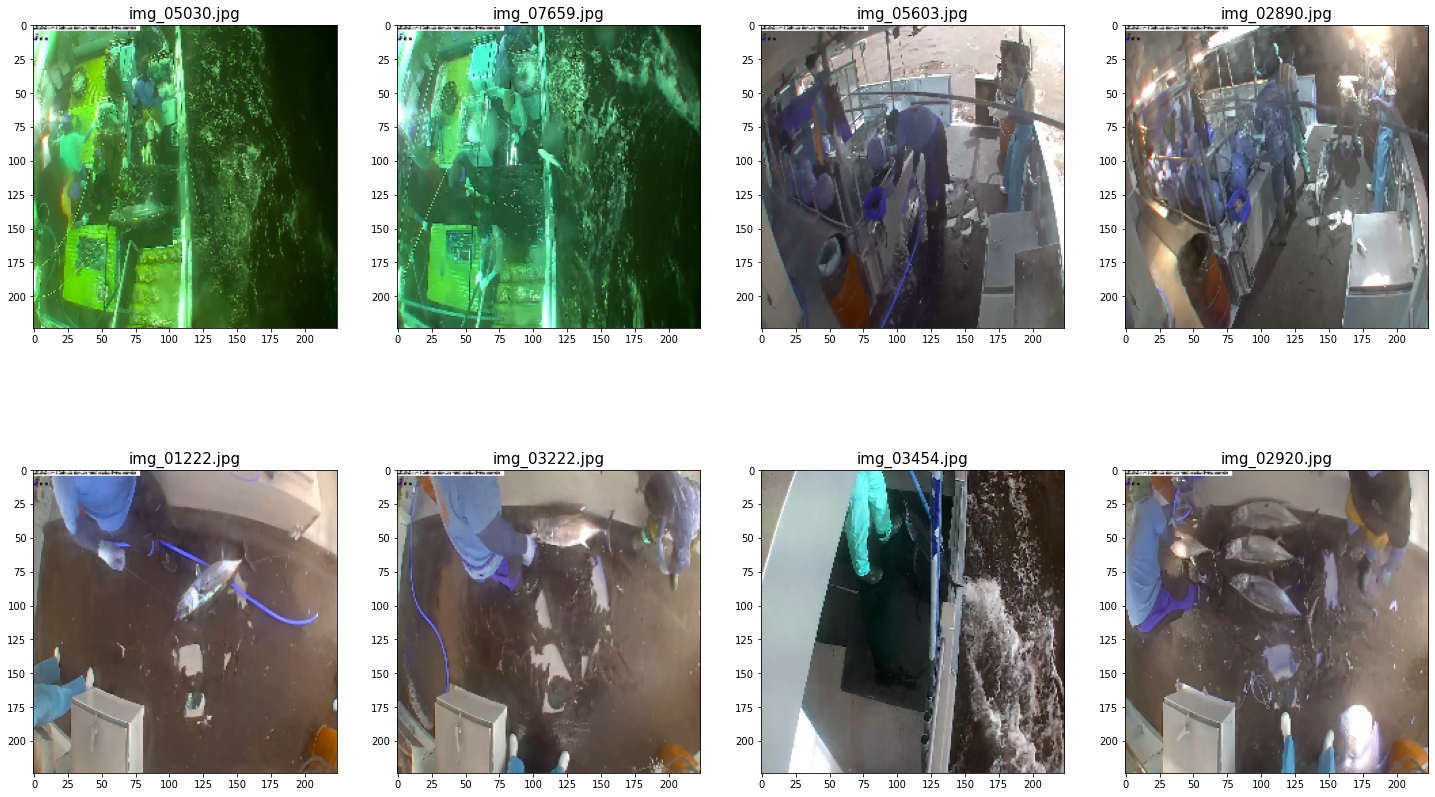

In [116]:
images_test = []
label_images = []
images_test_path = []



path = os.path.join(TEST_DIR, '*g')
files = glob.glob(path)

for file in files:
    file_name = os.path.basename(file)#'img_06053.jpg'
    img = load_images(file)#array([[[180, 202, 200]...
    images_test.append(img)#array([[[255, 255, 254]
    label_images.append(file_name)
    images_test_path.append(file)

        
fig, axs = plt.subplots(2, 4, figsize=(25, 15))

for ax, img, label in zip(axs.flatten(), images_test, label_images):
    ax.set_title(label, fontsize=15)
    ax.imshow(img)


plt.show()        

In [117]:
test_df = pd.DataFrame()

test_df['path'] = images_test_path
test_df['image'] = test_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
test_df.head()

path      image
0  data/fish/test_stg1/img_05030.jpg  img_05030
1  data/fish/test_stg1/img_07659.jpg  img_07659
2  data/fish/test_stg1/img_05603.jpg  img_05603
3  data/fish/test_stg1/img_02890.jpg  img_02890
4  data/fish/test_stg1/img_01222.jpg  img_01222

In [118]:
IMG_SIZE = (100, 100)

batch_size=2

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True)


test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="path",
    y_col="image",
    target_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',)

Found 16 validated image filenames belonging to 16 classes.


In [119]:
pred_Y =  model.predict_generator(test_generator, verbose = 1)

8/8 [==============================] - 1s 115ms/step


In [120]:
pred_Y[0]

array([4.0237592e-05, 6.9068096e-06, 9.1075484e-04, 2.6179795e-04,
       7.4027810e-07, 4.6964027e-02, 9.4811696e-01, 3.6984906e-03],
      dtype=float32)

In [121]:
submission = pd.DataFrame()

submission['image'] = X_test['image']

In [122]:
unique_labels = np.unique(label_photos)
unique_labels

array(['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'],
      dtype='<U5')

In [123]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

encoder.fit(unique_labels)
encoder.transform(unique_labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [124]:
for i,label in enumerate(list(unique_labels)):
    print(i,label)

0 ALB
1 BET
2 DOL
3 LAG
4 NoF
5 OTHER
6 SHARK
7 YFT


In [125]:
for i,label in enumerate(list(unique_labels)):
    submission[label] = pred_Y[:,i]

In [126]:
submission

image       ALB           BET           DOL           LAG  \
0   img_05030  0.000040  6.906810e-06  9.107548e-04  2.617979e-04   
1   img_07659  0.965729  1.413712e-05  4.245746e-06  1.677615e-02   
2   img_05603  0.970784  1.657525e-03  3.711710e-05  4.090448e-03   
3   img_02890  0.918639  1.868825e-06  6.534917e-05  2.304564e-02   
4   img_01222  0.000532  7.829584e-06  5.621239e-03  5.566828e-03   
5   img_03222  0.025951  1.264633e-01  1.049426e-02  1.133049e-01   
6   img_03454  0.007432  3.940377e-03  3.035328e-01  7.020011e-03   
7   img_02920  0.000463  1.438377e-02  3.655887e-08  9.368008e-01   
8   img_03941  0.001738  5.922054e-09  5.024442e-03  2.419870e-04   
9   img_03439  0.000019  2.190630e-05  1.623003e-06  3.978776e-06   
10  img_02188  0.993268  6.021012e-04  4.975693e-05  3.921306e-03   
11  img_00282  0.768733  2.258009e-03  1.285750e-02  1.844269e-01   
12  img_03140  0.012485  3.174246e-07  1.615675e-02  6.788316e-01   
13  img_00618  0.034475  1.117814e-04  9.034325e-06  7.317632e-05   
14  img_01116  0.634034  9.101084e-06  1.888612e-07  8.476629e-07   
15  img_03584  0.999404  2.164162e-06  5.290542e-06  1.436571e-05   

             NoF         OTHER     SHARK           YFT  
0   7.402781e-07  4.696403e-02  0.948117  3.698491e-03  
1   3.029555e-03  1.441225e-02  0.000022  1.291049e-05  
2   1.081427e-06  1.566970e-04  0.012735  1.053817e-02  
3   1.421026e-05  5.935624e-04  0.057638  2.772467e-06  
4   1.641647e-05  1.677192e-01  0.820521  1.525800e-05  
5   2.953726e-02  5.496528e-01  0.143882  7.146849e-04  
6   9.738583e-09  6.760198e-01  0.000446  1.609017e-03  
7   3.905368e-02  8.701270e-03  0.000005  5.923922e-04  
8   1.869053e-03  9.911070e-01  0.000018  1.554718e-06  
9   1.578071e-06  1.839125e-05  0.999920  1.355336e-05  
10  3.242229e-07  7.327147e-04  0.001425  6.263976e-07  
11  8.558575e-09  2.920574e-02  0.001399  1.120011e-03  
12  3.495035e-05  2.922704e-01  0.000220  7.389963e-07  
13  1.378500e-05  1.214629e-05  0.965300  4.966641e-06  
14  1.906723e-06  3.106839e-07  0.363482  2.472207e-03  
15  6.902535e-12  1.673817e-06  0.000568  4.760736e-06

# Пробуем определить наличие рыб на картинке

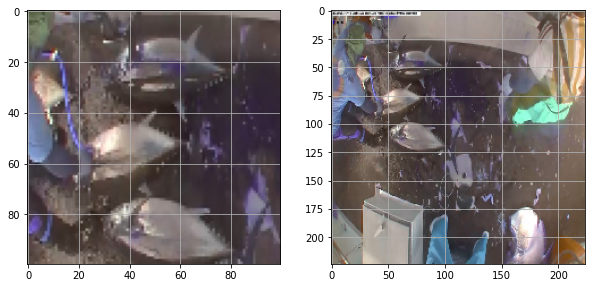

In [5]:
img_rows, img_cols= 100, 100

template = np.zeros([img_cols, img_rows, 3], dtype='uint8')
template = images[5][25:125,20:120]

fig =  plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.grid()
ax2.grid()

ax1.imshow(template, cmap='gray')
ax2.imshow(images[5], cmap='gray')

plt.show()

Кропать руками занимает давольно много времни, воспользоваться готовой разметкой

In [127]:
import numpy as np
import cv2
import json
import glob
import os

OUTPUT_DIR = 'data/fish/output/'

X_train = []


def make_cropped_dataset():
    label_files = glob.glob('data/fish/boxes/*.json')
    for file in label_files:
        process_labels(file)

def process_labels(label_file):
    file_name = os.path.basename(label_file)
    class_name = file_name.split("_")[0]

    with open(label_file) as data_file:
        data = json.load(data_file)

    for img_data in data:
        
        basename = os.path.basename(img_data['filename'])
    
        img_file  = os.path.join(
                    TRAIN_DIR, class_name.upper(), basename)
      
        img = cv2.imread(img_file)
        if os.path.exists(img_file):
                      
            if len(img_data['annotations']) >= 2:
                
                X_train.append(load_images(img_file))
                
                p_heads = (img_data['annotations'][0]['x'], img_data['annotations'][0]['y'])
                p_tails = (img_data['annotations'][1]['x'], img_data['annotations'][1]['y'])
                
                p_middle = ((p_heads[0] + p_tails[0]) / 2, (p_heads[1] + p_tails[1]) / 2)
                
                dist = np.sqrt((p_heads[0] - p_tails[0]) ** 2 + (p_heads[1] - p_tails[1]) ** 2)
                offset = 3.0 * dist / 4.0
                
                img_width = img.shape[1]
                img_height = img.shape[0]
                
                x_left = max(0, p_middle[0] - offset)
                x_right = min(img_width - 1, p_middle[0] + offset)
                
                y_up = max(0, p_middle[1] - offset)
                y_down = min(img_height - 1, p_middle[1] + offset)
                
                x_left, x_right, y_up, y_down = int(x_left), int(x_right), int(y_up), int(y_down)
  
                img = img[y_up:y_down+1, x_left:x_right+1, :]            
                
                if not os.path.isdir(OUTPUT_DIR + class_name.upper() + '/'):
                    os.mkdir(OUTPUT_DIR + class_name.upper() + '/' )
                cv2.imwrite(OUTPUT_DIR + class_name.upper() + '/' + img_data['filename'], img) 
                
                print(OUTPUT_DIR + class_name.upper() + '/' + img_data['filename'])

**Загружаем кропнутые фотографии**

In [128]:
CROP_DIR = 'data/fish/output/'

sub_folders = check_output(["ls", CROP_DIR]).decode("utf8").strip().split('\n')

photos = []
photos_path = []
label_photos = []

for sub_dir in sub_folders:
    index = sub_folders.index(sub_dir)
    print('Loading {} files (Index: {})'.format(sub_dir, index))
    path = os.path.join(CROP_DIR, sub_dir, '*g')
    files = glob.glob(path)
    for file in files:
        file_name = os.path.basename(file)#'img_06053.jpg'

        img = load_images(file)#array([[[180, 202, 200]...
        
        photos.append(img)#array([[[255, 255, 254]
        photos_path.append(file)
        label_photos.append(sub_dir)   

Loading ALB files (Index: 0)
Loading BET files (Index: 1)
Loading LAG files (Index: 2)
Loading YFT files (Index: 3)


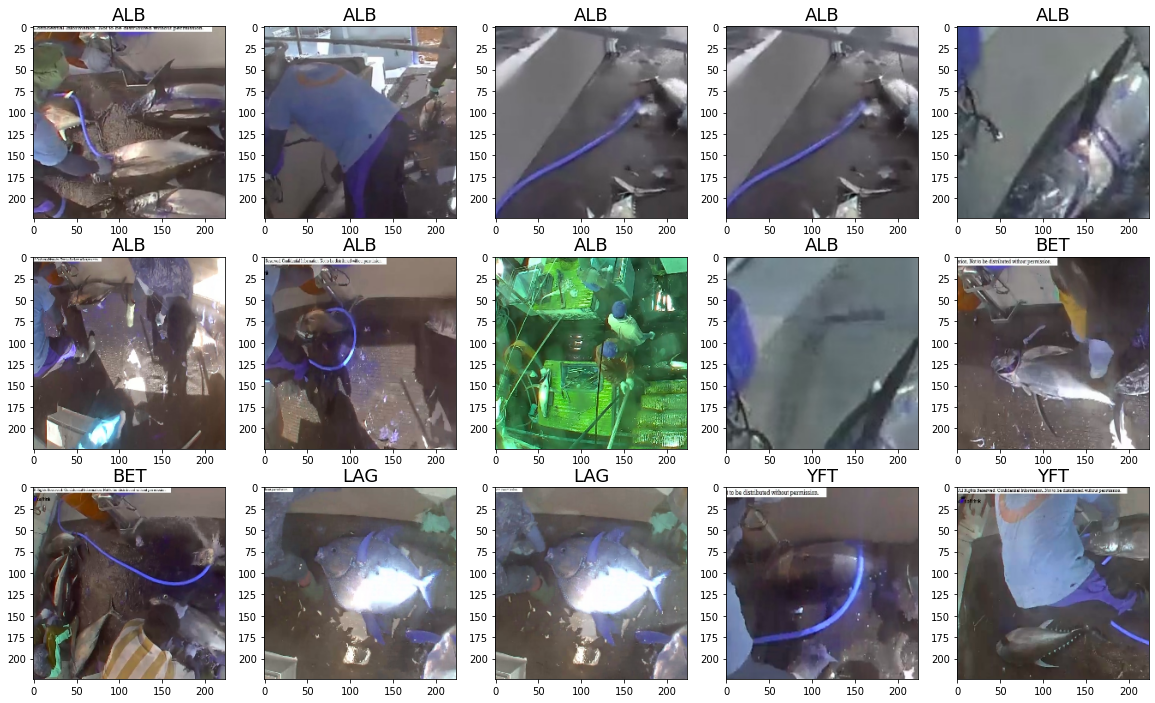

In [129]:
fig, axs = plt.subplots(3, 5, figsize=(20, 12))

for ax, img, label in zip(axs.flatten(), photos, label_photos):
    ax.set_title(label, fontsize=18)
    ax.imshow(img)


plt.show()

Как обучать алгоритм по крпнутым фотографиям так и не придумал... Если есть мысли по этому поводу, поделитесь пожалуйста :)

# YOLO

In [23]:
%pwd

'/home/user/Downloads/21'

In [24]:
%cd yolo

/home/user/Downloads/21/yolo


In [4]:
#загружаем предобученные веса для модели 53
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2020-12-01 11:11:48--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154,96M   270KB/s    in 17m 26s 

2020-12-01 11:29:17 (152 KB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [25]:
#yolo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 14558 (delta 13), reused 19 (delta 8), pack-reused 14522
Receiving objects: 100% (14558/14558), 13.24 MiB | 2.74 MiB/s, done.
Resolving deltas: 100% (9890/9890), done.


In [ ]:
#компиляция Darknet с использованием Nvidia GPU

%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

In [9]:
#компиляция Darknet с использованием CPU

%cd darknet
!make

chmod +x *.sh


In [27]:
#настраиваем Darknet для тренировки YOLO V3
!cp cfg/yolov3.cfg cfg/yolov3_training.cfg

In [28]:
!sed -i 's/batch=1/batch=64/' cfg/yolov3_training.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg
!sed -i 's/max_batches = 500200/max_batches = 4000/' cfg/yolov3_training.cfg
!sed -i '610 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '696 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '783 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '603 s@filters=255@filters=18@' cfg/yolov3_training.cfg
!sed -i '689 s@filters=255@filters=18@' cfg/yolov3_training.cfg
!sed -i '776 s@filters=255@filters=18@' cfg/yolov3_training.cfg

In [29]:
%pwd

'/home/user/Downloads/21/yolo/darknet'

In [30]:
%cd ..

/home/user/Downloads/21/yolo


In [11]:
#создаем папку для хранения весов
!mkdir "yolov3"

In [8]:
%ls

darknet/  darknet53.conv.74  yolo_labels_img.zip  yolov3/  yolov3_testing.cfg


In [18]:
!echo "fish" > yolov3/obj.names

!echo -e 'classes= 1\ntrain  =  yolov3/train.txt\nvalid  =  yolov3/test.txt\nnames =  yolov3/obj.names\nbackup =  yolov3/yolov3' >  yolov3/obj.data
!mkdir  yolov3/obj

mkdir: cannot create directory ‘yolov3/obj’: File exists


In [ ]:
!unzip yolo_labels_img.zip -d yolov3/obj

In [1]:
%pwd

'/home/user/Downloads/21'

In [25]:
#Мы собираемся преобразовать индекс класса в файлах .txt. 
#Поскольку мы работаем только с одним классом, это должен быть класс 0.
#Если индекс отличается от 0, мы собираемся его изменить.
import glob
import os
import re

txt_file_paths = glob.glob(r"yolov3/obj/yolo_labels_img/*.txt")
for i, file_path in enumerate(txt_file_paths):
    # Получить размер изображения
    with open(file_path, "r") as f_o:
        lines = f_o.readlines()

        text_converted = []
        for line in lines:
            print(line)
            numbers = re.findall("[0-9.]+", line)
            print(numbers)
            if numbers:

                # Определить координаты
                text = "{} {} {} {} {}".format(0, numbers[1], numbers[2], numbers[3], numbers[4])
                text_converted.append(text)
                print(i, file_path)
                print(text)
        # Запись в файл
        with open(file_path, 'w') as fp:
            for item in text_converted:
                fp.writelines("%s\n" % item)

0 0.218359 0.584028 0.122656 0.098611

['0', '0.218359', '0.584028', '0.122656', '0.098611']
0 yolov3/obj/yolo_labels_img/img_05663.txt
0 0.218359 0.584028 0.122656 0.098611
0 0.486997 0.938060 0.098154 0.123881

['0', '0.486997', '0.938060', '0.098154', '0.123881']
1 yolov3/obj/yolo_labels_img/img_05225.txt
0 0.486997 0.938060 0.098154 0.123881
0 0.587891 0.393056 0.344531 0.419444

['0', '0.587891', '0.393056', '0.344531', '0.419444']
2 yolov3/obj/yolo_labels_img/img_02758.txt
0 0.587891 0.393056 0.344531 0.419444
0 0.756641 0.793750 0.317969 0.412500

['0', '0.756641', '0.793750', '0.317969', '0.412500']
2 yolov3/obj/yolo_labels_img/img_02758.txt
0 0.756641 0.793750 0.317969 0.412500
0 0.605469 0.528747 0.246875 0.168378

['0', '0.605469', '0.528747', '0.246875', '0.168378']
3 yolov3/obj/yolo_labels_img/img_01639.txt
0 0.605469 0.528747 0.246875 0.168378
0 0.582812 0.767361 0.131250 0.293056

['0', '0.582812', '0.767361', '0.131250', '0.293056']
4 yolov3/obj/yolo_labels_img/img_0482

In [29]:
images_list = glob.glob("yolov3/obj/yolo_labels_img/*.jpg")
print(images_list[:5])

['yolov3/obj/yolo_labels_img/img_00714.jpg', 'yolov3/obj/yolo_labels_img/img_07540.jpg', 'yolov3/obj/yolo_labels_img/img_07038.jpg', 'yolov3/obj/yolo_labels_img/img_01083.jpg', 'yolov3/obj/yolo_labels_img/img_04495.jpg']


In [30]:
#Create training.txt file
file = open("yolov3/train.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

In [6]:
%cd ..

/home/user/Downloads/21


In [2]:
%cd yolo

/home/user/Downloads/21/yolo


In [ ]:
# Начинаем обучение
!darknet/./darknet detector train yolov3/obj.data darknet/cfg/yolov3_training.cfg darknet53.conv.74

<img src='yolo/chart.png'>

In [1]:
%pwd

'/home/user/Downloads/21'

In [2]:
%cd yolo

/home/user/Downloads/21/yolo


In [3]:
!ls

chart.png		   darknet53.conv.74	yolov3_testing.cfg
chart_yolov3_training.png  yolo_labels_img.zip
darknet			   yolov3


In [27]:
import cv2
import numpy as np
import random
import glob

# Загрузка Yolo
net = cv2.dnn.readNet("yolov3/backup/yolov3_training_last.weights", "yolov3_testing.cfg")

# Название класса
classes = ["fish"]

images_path = glob.glob("../data/fish/test_stg1/*.jpg")

In [28]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

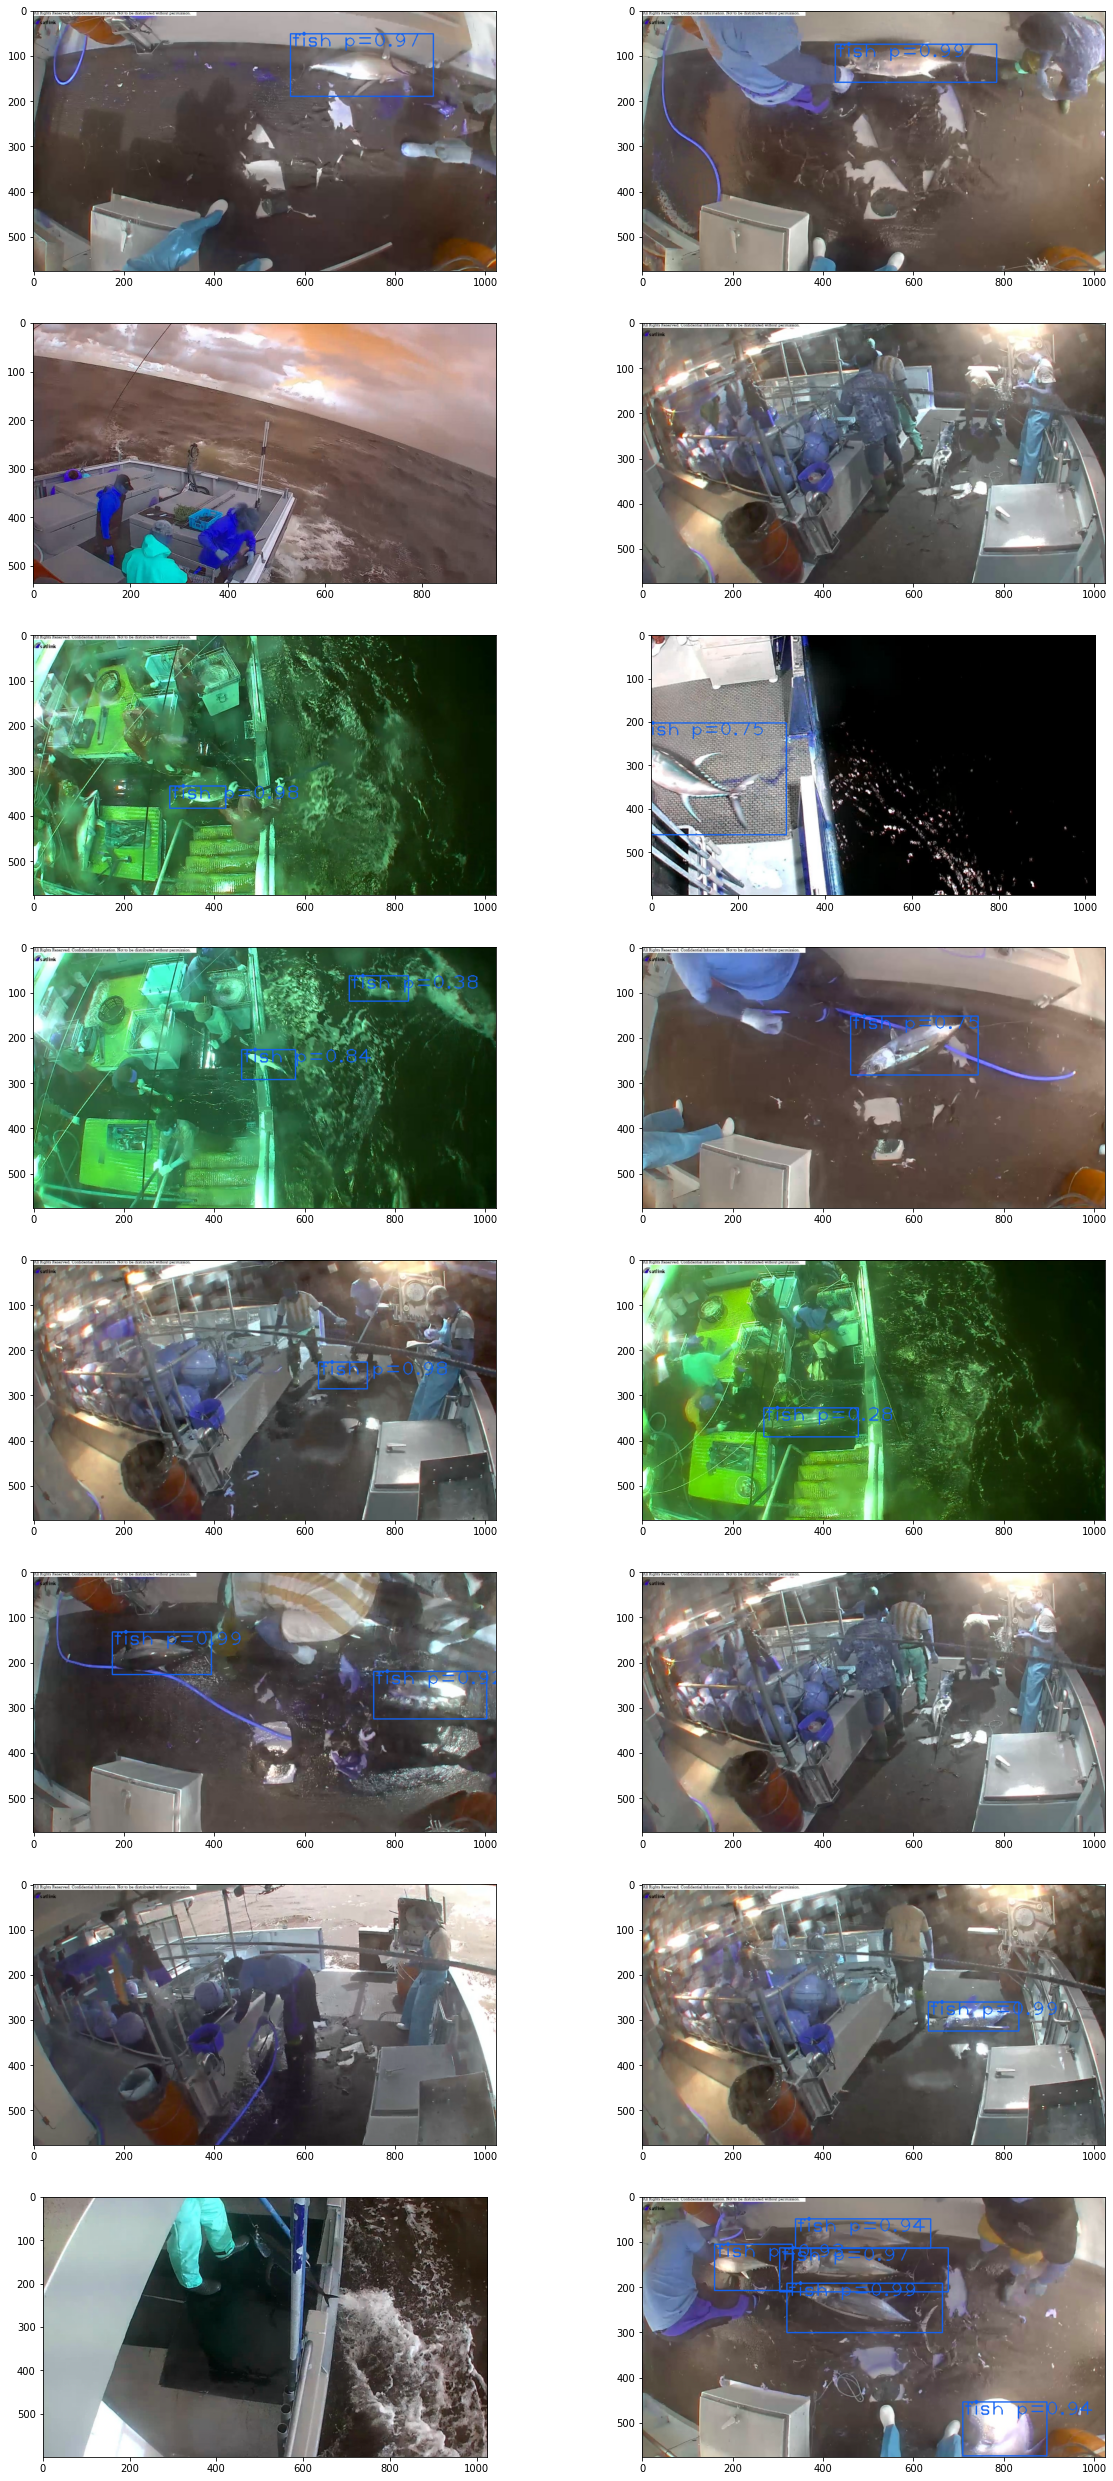

In [69]:
import matplotlib.pyplot as plt

random.shuffle(images_path)

fig, axs = plt.subplots(8, 2, figsize=(20, 45))

for idx, img_path in enumerate(images_path):
 
    img = cv2.imread(img_path)
    img = cv2.resize(img, None, fx=0.8, fy=0.8)
    height, width, channels = img.shape

    # Определяю объект
    #0.00392 - масштабирование
    blob = cv2.dnn.blobFromImage(img, 0.00392, (832, 832), (0, 0, 0), True, crop=False)

    net.setInput(blob)#входной слой
    outs = net.forward(output_layers)#выходной слой

   
    class_ids = []
    confidences = []
    boxes = []
    
    #Переберем выходной слой
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.2:
                # Определение объекта
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Координаты прямоугольника
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)#подавляет не максимальные знаения.
    font = cv2.FONT_HERSHEY_PLAIN
    
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]] + ' p=' + str(confidences[i])[:4])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y + 30), font, 3, color, 2)


    axs = axs.flatten()
    axs[idx].imshow(img)      
        

